In [56]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

from collections import Counter
import re

In [57]:
df = pd.read_csv('../data/Sei/Sei_tracks_info.csv')

df_pivot = df.pivot_table(
    values="index", 
    index="cell_type", 
    columns="assay", 
    aggfunc=list,
)
df_pivot = df_pivot.map(lambda x: x if isinstance(x, list) else [])
df_pivot

assay                    ADNP AEBP2 AFF1 AFF4 AGO1 AGO2 AHR AHRR AP-2alpha AP-2gamma APOBEC3B  AR ARID1A ARID2 ARID3A ARID5B ARNT ARNT2 ARNTL ARRB1 ASCL1 ASCL2 ASH1L ASH2L ASXL1 ATAC-seq ATF1 ATF2 ATF3 ATF4 ATF5 ATF7IP ATOH1 ATRX AUTS2 BACH1 BACH2 BAF155 BAF170 BAHD1 BANF1 BANP BARX1 BARX2 BATF BATF3 BCAT1 BCL11A BCL11B BCL3 BCL6 BCLAF1 BCOR BDP1 BHLHE40 BIRA BMI1 BPTF BRAF BRCA1 BRD1 BRD2    BRD3    BRD4 BRD7 BRD9 BRDU BRF1 BRF2 BRPF3 BTAF1 Bach1 Brg1 C11orf30 C17orf49 C17orf96 CAMTA2 CASP8AP2 CBFA2T2 CBFB CBX1 CBX2 CBX3 CBX4 CBX5 CBX6 CBX7 CBX8 CCDC101 CCND2 CCNT2 CD59 CD74 CDC5L CDCA2 CDK12 CDK2 CDK6 CDK7 CDK8 CDK9 CDX2 CEBPA CEBPB CEBPD CEBPG CEBPZ CENPA CENPC CENPT CHAMP1 CHAT CHD1 CHD2 CHD4 CHD5 CHD7 CHD8 CHRM2 CIITA CLOCK CNOT3 COPS2 COREST CPSF3L CREB1 CREB3 CREB3L4 CREBBP CREM CRY1 CSDE1 CSNK2A1 CTBP1 CTBP2 CTCF CTCFL CTNNB1 CUX1 CtBP2 DACOR1 DAXX DCP1A DDX20 DDX21 DDX5 DEAF1 DEK DIDO1 DLX1 DLX2 DMC1 DNMT1 DNMT3A DNMT3B    DNase DNase.all.peaks DNase.fdr0.01.hot  \
cell_type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
1015c                      []    []   []   []   []   []  []   []        []        []       []  []     []    []     []     []   []    []    []    []    []    []    []    []    []       []   []   []   []   []   []     []    []   []    []    []    []     []     []    []    []   []    []    []   []    []    []     []     []   []   []     []   []   []      []   []   []   []   []    []   []   []      []  [8996]   []   []   []   []   []    []    []    []   []       []       []       []     []       []      []   []   []   []   []   []   []   []   []   []      []    []    []   []   []    []    []    []   []   []   []   []   []   []    []    []    []    []    []    []    []    []     []   []   []   []   []   []   []   []    []    []    []    []    []     []     []    []    []      []     []   []   []    []      []    []    []   []    []     []   []    []     []   []    []    []    []   []    []  []    []   []   []   []    []     []     []       []              []                []   
10326                      []    []   []   []   []   []  []   []        []        []       []  []     []    []     []     []   []    []    []    []    []    []    []    []    []       []   []   []   []   []   []     []    []   []    []    []    []     []     []    []    []   []    []    []   []    []    []     []     []   []   []     []   []   []      []   []   []   []   []    []   []   []  [8997]      []   []   []   []   []   []    []    []    []   []       []       []       []     []       []      []   []   []   []   []   []   []   []   []   []      []    []    []   []   []    []    []    []   []   []   []   []   []   []    []    []    []    []    []    []    []    []     []   []   []   []   []   []   []   []    []    []    []    []    []     []     []    []    []      []     []   []   []    []      []    []    []   []    []     []   []    []     []   []    []    []    []   []    []  []    []   []   []   []    []     []     []       []              []                []   
1184_Stem_cell             []    []   []   [

In [58]:
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF'] #, 'ATAC-seq']

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
cell_standard_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma', 'SK-N-SH_Neuroblastoma_cell_Brain', 'HCT-116_Colorectal_cancer_cell_line', 'A549', 'SK-N-SH_RA_Neuron_Brain']

In [59]:
df_track = pd.DataFrame(index=cell_types, columns=assays)

for i, cell_type in enumerate(cell_types):
    cell_standard_name = cell_standard_names[i]
    df_track.loc[cell_type] = df_pivot.loc[cell_standard_name]

df_track.loc['SK-N-SH'] = df_pivot.loc['SK-N-SH_Neuroblastoma_cell_Brain'] + df_pivot.loc['SK-N-SH_RA_Neuron_Brain']

df_track.map(len)

,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
K562,58,91,51,34,11,5,29,29
HepG2,9,8,9,2,4,3,2,17
SK-N-SH,4,4,3,1,0,1,0,7
HCT116,6,45,49,5,23,4,1,14
A549,4,45,53,3,37,1,27,10


In [60]:
pred_array = load_h5('outputs/cCRE_Sei_pred.h5')
print(pred_array.shape)

(368038, 21907)


In [61]:
MPRA_df = pd.read_csv('../data/cCRE/cCRE_5_cell_types.csv')
print(MPRA_df.shape)

(368038, 12)


In [62]:
for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        indice = df_track.loc[cell_type, assay]
        if len(indice) > 0:
            pred_feature = pred_array[:, indice].mean(1)
            MPRA_df[f'{cell_type}_{assay}'] = pred_feature
        else:
            MPRA_df[f'{cell_type}_{assay}'] = np.nan

MPRA_df

,chr,start,end,name_1,name_2,cCRE_type,K562_cCRE_type,HepG2_cCRE_type,SK-N-SH_cCRE_type,HCT116_cCRE_type,A549_cCRE_type,seq,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF
0,chr1,115562,115912,EH38F0000002,EH38E3951280,CA-CTCF,CA-CTCF,Low-DNase,Low-DNase,Low-DNase,Low-DNase,CAGATTATACTACAGTGAAAGTTGCCAATGACAAGGCAAAGTCACT...,0.067,0.008,0.011,0.002,0.019,0.001,0.003,0.010,0.003,0.003,0.002,0.003,0.003,0.000,0.039,0.007,0.008,0.005,0.002,0.008,NaN,0.000,NaN,0.006,0.013,0.002,0.002,0.010,0.004,0.000,0.006,0.005,0.040,0.003,0.003,0.013,0.003,0.000,0.001,0.008
1,chr1,138917,139112,EH38D6144710,EH38E3951286,pELS,pELS,Low-DNase,Low-DNase,Low-DNase,Low-DNase,GAGGCAGGAGCTGGGCCTGGACAGGTCAACTTGAGGAGATTTTGGG...,0.237,0.001,0.001,0.001,0.002,0.001,0.063,0.508,0.127,0.001,0.001,0.001,0.000,0.001,0.027,0.778,0.047,0.001,0.000,0.003,NaN,0.001,NaN,0.714,0.690,0.002,0.002,0.001,0.005,0.000,0.001,0.787,0.496,0.001,0.001,0.001,0.000,0.000,0.001,0.786
2,chr1,181014,181237,EH38D4327524,EH38E2776523,CA-H3K4me3,Low-DNase,Low-DNase,Low-DNase,CA-only,Low-DNase,GGCCCGCCCGCCCGGGTCTGACCTGAGGAGAACTGTGCTCCGCCTT...,0.660,0.057,0.011,0.002,0.010,0.001,0.108,0.040,0.287,0.065,0.004,0.003,0.002,0.001,0.015,0.031,0.590,0.090,0.007,0.009,NaN,0.000,NaN,0.082,0.527,0.065,0.011,0.009,0.015,0.001,0.021,0.018,0.680,0.115,0.020,0.007,0.002,0.000,0.002,0.048
3,chr1,181289,181639,EH38D4327525,EH38E2776524,CA-H3K4me3,CA-CTCF,CA-TF,CA-TF,CA-only,CA-only,CGCGCCGGCGCAGGCGCAGAGAGGCGCGCCGCGCCGGCGCAGGCGC...,0.466,0.013,0.003,0.001,0.002,0.001,0.150,0.006,0.165,0.006,0.002,0.000,0.000,0.001,0.005,0.005,0.487,0.007,0.001,0.001,NaN,0.000,NaN,0.015,0.576,0.012,0.007,0.005,0.012,0.001,0.005,0.006,0.594,0.036,0.009,0.003,0.001,0.000,0.002,0.017
4,chr1,191294,191644,EH38D4327540,EH38E2776526,dELS,Low-DNase,Low-DNase,CA-only,Low-DNase,Low-DNase,ATCAGCAGGGACCGTGCACTCTCTTGGAGCCACCACAGAAAGCAGA...,0.013,0.004,0.001,0.005,0.005,0.000,0.245,0.001,0.044,0.007,0.001,0.033,0.003,0.001,0.041,0.004,0.395,0.008,0.001,0.084,NaN,0.000,NaN,0.017,0.017,0.005,0.001,0.061,0.003,0.000,0.003,0.001,0.031,0.003,0.000,0.044,0.001,0.000,0.001,0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368033,chrY,20828581,20828904,EH38D6144374,EH38E3951144,dELS,Low-DNase,Low-DNase,Low-DNase,Low-DNase,CA-TF,TGGAAGAATTTAAAACAGAAATACCAGGCTGGGCGCGGTGGCTCAG...,0.010,0.007,0.003,0.002,0.002,0.000,0.115,0.000,0.020,0.015,0.027,0.001,0.003,0.000,0.003,0.001,0.000,0.004,0.006,0.002,NaN,0.000,NaN,0.000,0.070,0.033,0.036,0.002,0.174,0.000,0.000,0.001,0.072,0.028,0.019,0.001,0.003,0.000,0.001,0.001
368034,chrY,21021830,21022179,EH38D6144412,EH38E3951161,dELS,Low-DNase,dELS,Low-DNase,Low-DNase,Low-DNase,GCCAGTGGAAATCTTGTTGGGTTTCTCTCGTCCCACTAATGTTACC...,0.048,0.003,0.006,0.003,0.047,0.004,0.006,0.001,0.715,0.075,0.140,0.004,0.135,0.001,0.020,0.013,0.037,0.018,0.202,0.021,NaN,0.001,NaN,0.003,0.870,0.037,0.104,0.002,0.368,0.001,0.000,0.008,0.911,0.095,0.077,0.007,0.025,0.001,0.003,0.019
368035,chrY,26315142,26315389,EH38D4327358,EH38E2776433,CA-CTCF,CA-CTCF,Low-DNase,Low-DNase,Low-DNase,CA-TF,AATCTGCATTCCCTATACTAAAACACTTAAATGGAATGGGATAGAA...,0.300,0.001,0.001,0.001,0.002,0.001,0.003,0.562,0.088,0.003,0.000,0.000,0.001,0.000,0.010,0.807,0.212,0.005,0.001,0.001,NaN,0.000,NaN,0.884,0.757,0.003,0.001,0.003,0.007,0.000,0.003,0.804,0.782,0.007,0.003,0.007,0.003,0.000,0.001,0.799
36

In [63]:
MPRA_df.to_csv('../data/cCRE/cCRE_5_cell_types_Sei_feature_0512.csv', index=False)

In [54]:
print(MPRA_df['seq'].str.len().min(), MPRA_df['seq'].str.len().max())

150 350


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'PLS'),
  Text(1, 0, 'pELS'),
  Text(2, 0, 'dELS'),
  Text(3, 0, 'CA-H3K4me3'),
  Text(4, 0, 'CA-CTCF'),
  Text(5, 0, 'CA-TF'),
  Text(6, 0, 'CA-only'),
  Text(7, 0, 'Low-DNase')])

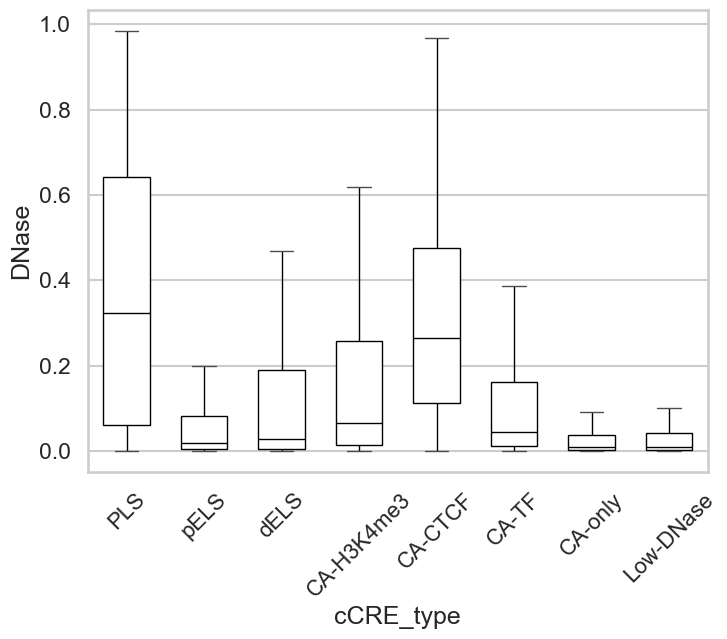

In [49]:
cCRE_types = ['PLS', 'pELS', 'dELS', 'CA-H3K4me3', 'CA-CTCF', 'CA-TF', 'CA-only', 'Low-DNase']

plot_data = []
for cell_type in cell_types[:1]:
    for cCRE_type in cCRE_types:
        df = MPRA_df[MPRA_df[f'{cell_type}_cCRE_type'] == cCRE_type]
        values = df[f'{cell_type}_DNase'].dropna()
        # plot_data.append(values)
        for v in values:
            plot_data.append({
                "cCRE_type": cCRE_type,
                "DNase": v
            })
            
plot_df = pd.DataFrame(plot_data)
sns.boxplot(data=plot_df, x="cCRE_type", y="DNase", fliersize=0, width=0.6,
            boxprops={"facecolor":"white", "edgecolor":"black"},
            whiskerprops={"color":"black"},
            medianprops={"color":"black"})
# sns.stripplot(data=plot_df, x="cCRE_type", y="DNase", color='black', jitter=True, size=3)

# plt.boxplot(x=plot_data, positions=range(len(cCRE_types)))
# plt.xticks(ticks=range(len(cCRE_types)), labels=cCRE_types, rotation=45)
# plt.ylabel('DNase')
plt.xticks(fontsize=16, rotation=45)